# **<span style="color:red">Imports</span>**

In [1]:
# Handy arrays
import numpy as np
# FFTs
import scipy.fft as fft
import scipy.fftpack as fftp

# Custom modules
import lib.utils.utils as Utils
import lib.utils.plotting as Plotting
import lib.utils.otf as OTF
import lib.methods.distortion as Distortion
import lib.methods.otf_restoration as OTF_Restoration

# **<span style="color:red">Notes</span>**

## **<span style="color:orange">Window functions</span>**

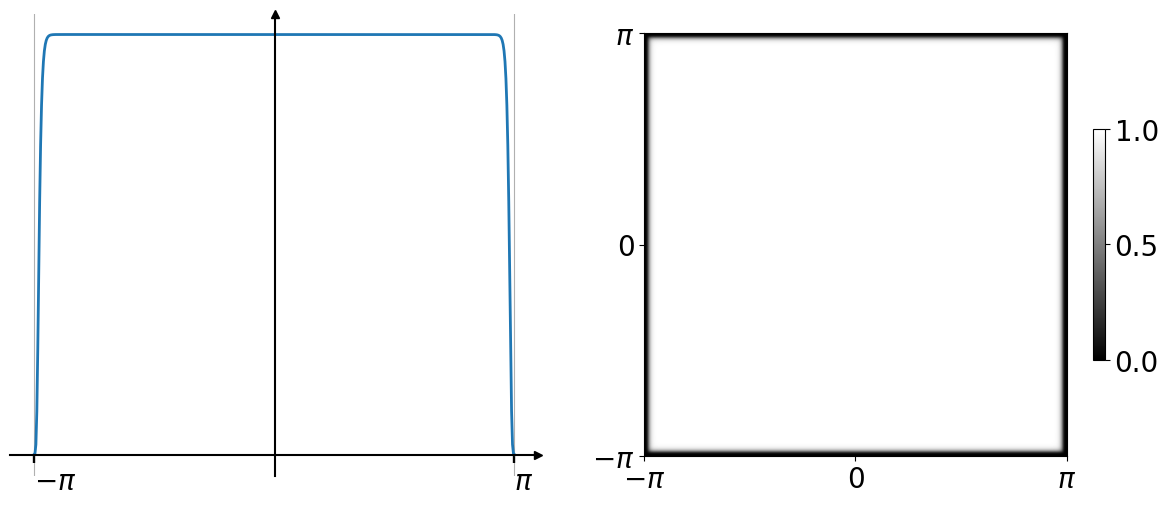

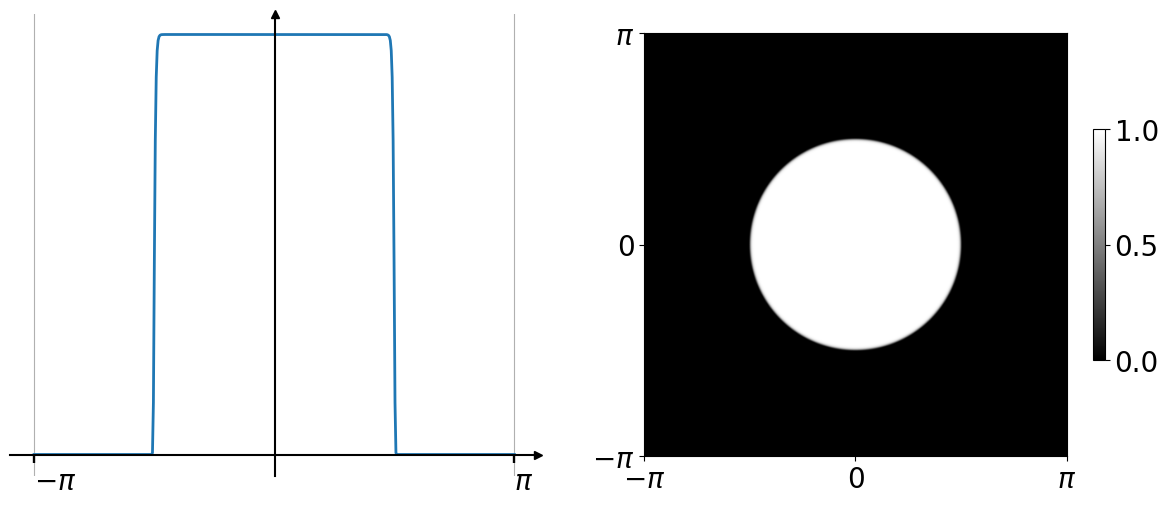

In [2]:
shape = (512,512)

window_func = Utils.create_super_gauss(shape, 10.8/11, 20, mode='square')
Plotting.plot_image(window_func, plot_cut=True, cut_index=256)

window_func = Utils.create_super_gauss(shape, 1/2, 20)
Plotting.plot_image(window_func, plot_cut=True, cut_index=256)

## **<span style="color:orange">White noise</span>**

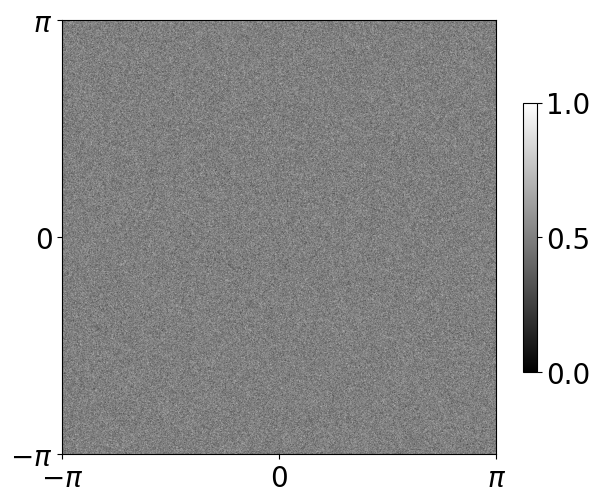

In [2]:
white_noise = np.random.random((2048, 2048))
Plotting.plot_image(white_noise)
#Utils.image_save(white_noise, 'Samples/Test_noise_1.png')

## **<span style="color:orange">PSF and OTF</span>**

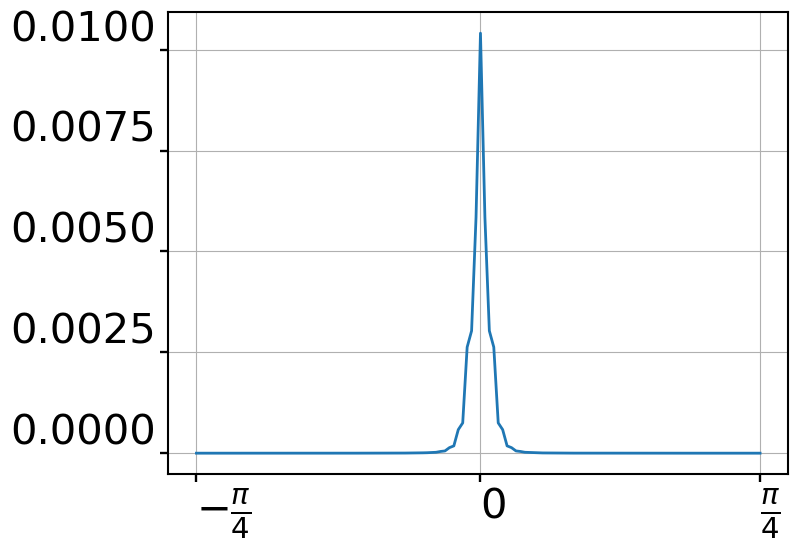

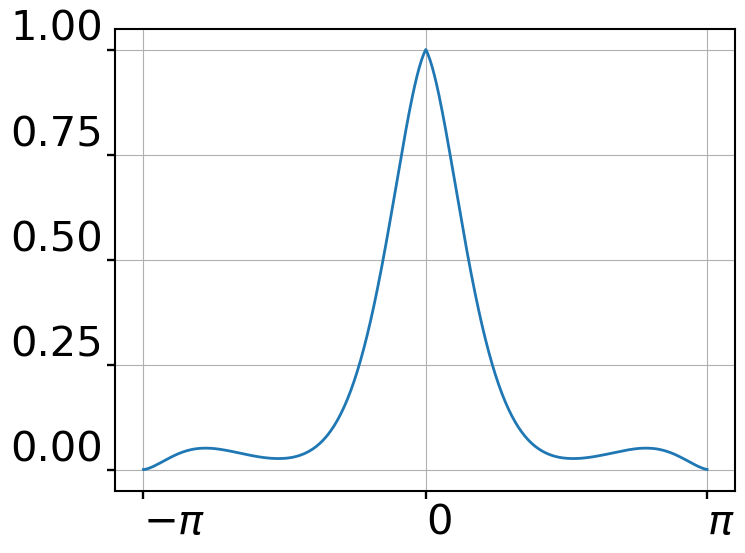

In [ ]:
a=10.1
folder = f'Results_(VKR)/PSF-OTF ({a})/'

psf = OTF.create_psf((512, 512), a)
otf = OTF.psf2otf(psf)

psf_cropped = Utils.image_crop_corners(fftp.fftshift(psf), ratio=0.375)
Plotting.plot_image(psf_cropped, axes_labels=[r'$-\frac{\pi}{4}$', 0, r'$\frac{\pi}{4}$'], plot_image=False,
                    plot_cut=True, cut_index=(psf_cropped.shape[0]//2),
                    plot_file=folder+'1, PSF.svg')
Plotting.plot_image(fftp.fftshift(otf.real), axes_labels=[r'$-\pi$', 0, r'$\pi$'], plot_image=False,
                    plot_cut=True, cut_index=(otf.shape[0]//2),
                    plot_file=folder+'2, OTF.svg')

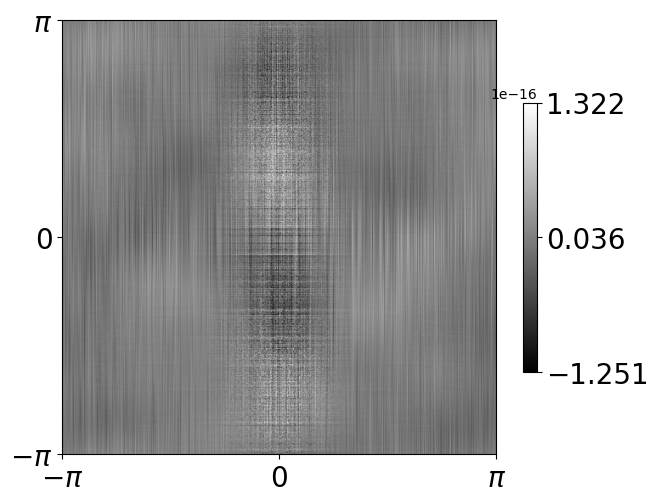

In [3]:
Plotting.plot_image(fftp.fftshift(otf.imag))

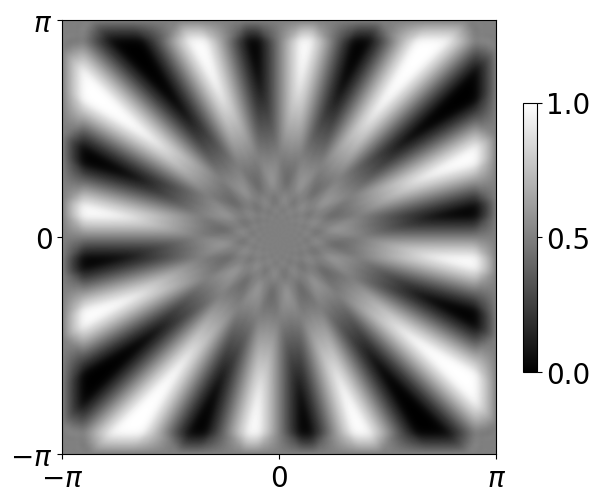

In [5]:
image = Utils.create_image((512, 512))
image += abs(np.min(image))
image_blurred = Distortion.image_distortion(image, a)
image_blurred = Utils.image_normalize(image_blurred)
Plotting.plot_image(image_blurred)

## **<span style="color:orange">Radial integration</span>**

In [6]:
def add_ring(image, r):
    # Half size of image as 1/2 of minimum from two sides
    half_shape = min(image.shape[0], image.shape[1])//2

    # Grid
    I,J = Utils.create_matrix_grid_indexes(image.shape)
    I,J = half_shape - J, I - half_shape
    # Radial length at each point
    points_radial_length = I**2 + J**2
   
    return (r**2 <= points_radial_length) * (points_radial_length < (r + 1)**2)

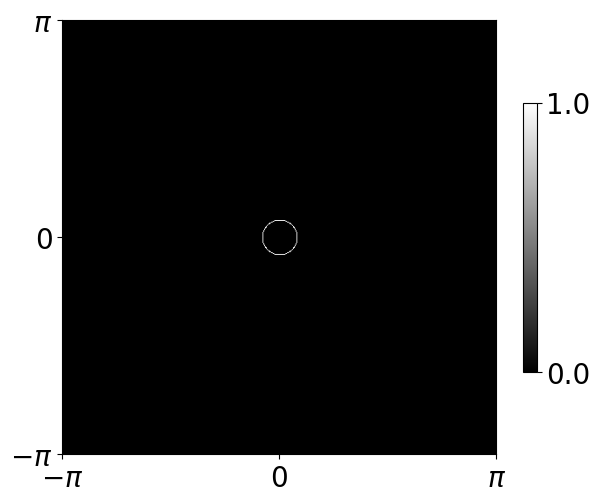

In [7]:
Plotting.plot_image(add_ring(np.empty((512, 512)), 20))

## **<span style="color:orange">Lower envelope</span>**

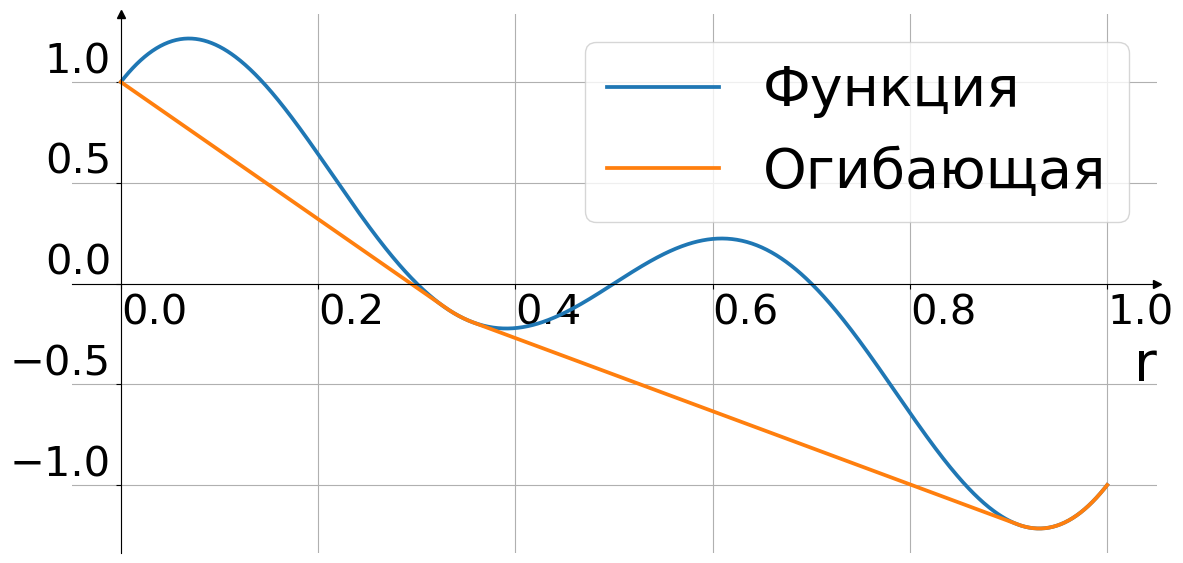

In [2]:
x = np.linspace(0., 1., 1000)
f = np.sin(2. * np.pi * x) + np.cos(3. * np.pi * x)
envelope = OTF_Restoration.get_lower_envelope(x, f)
Plotting.plot_functions([Plotting.FuncDesc(x, f, 'Функция'),
                         Plotting.FuncDesc(x, envelope, 'Огибающая')], x_axis_name='r')

## **<span style="color:orange">Different envelope norms</span>**

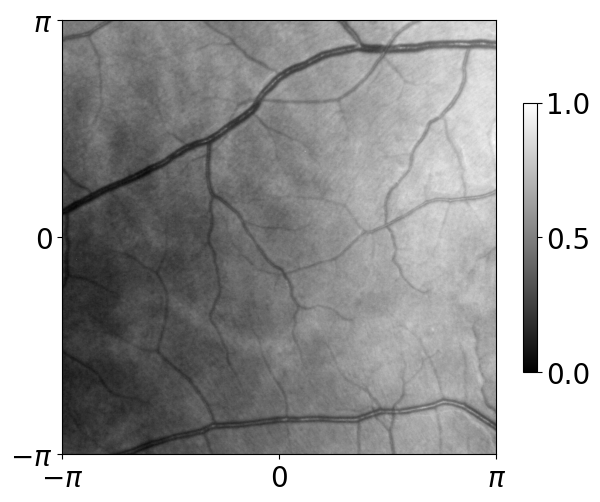

In [7]:
image = Utils.image_load('Samples/Test_image_1.png', (slice(512, 1536), slice(512, 1536)))
Plotting.plot_image(image)

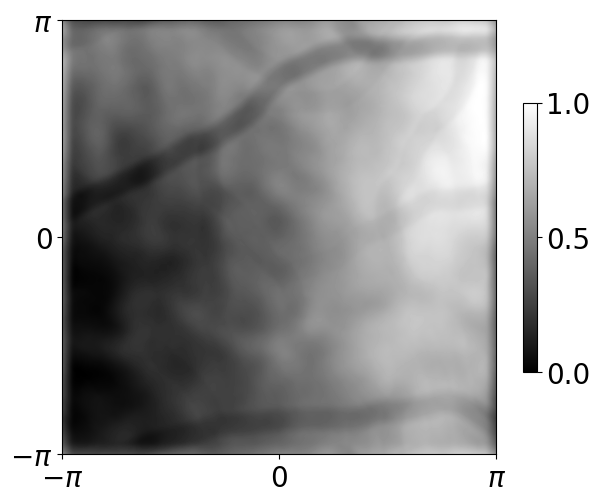

In [8]:
image_blurred = Distortion.image_distortion(image, 10)
image_blurred = Utils.image_normalize(image_blurred)
Plotting.plot_image(image_blurred)

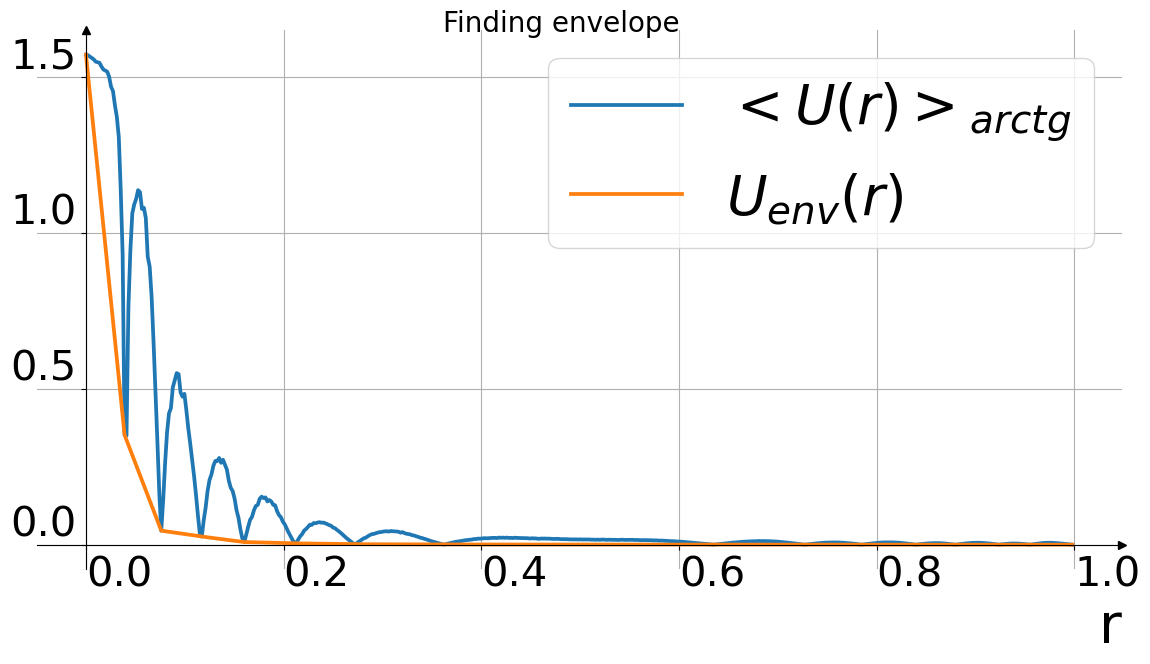

In [9]:
average_angled_spectrum = OTF_Restoration.average_angled_spectrum(image_blurred, k=0.1)
x = np.arange(0, 1, 1 / average_angled_spectrum.shape[0])
envelope = OTF_Restoration.get_lower_envelope(x, average_angled_spectrum)
Plotting.plot_functions([Plotting.FuncDesc(x, average_angled_spectrum, r'$<U(r)>_{arctg}$'),
                         Plotting.FuncDesc(x, envelope, r'$U_{env}(r)$')], title='Finding envelope', x_axis_name='r')

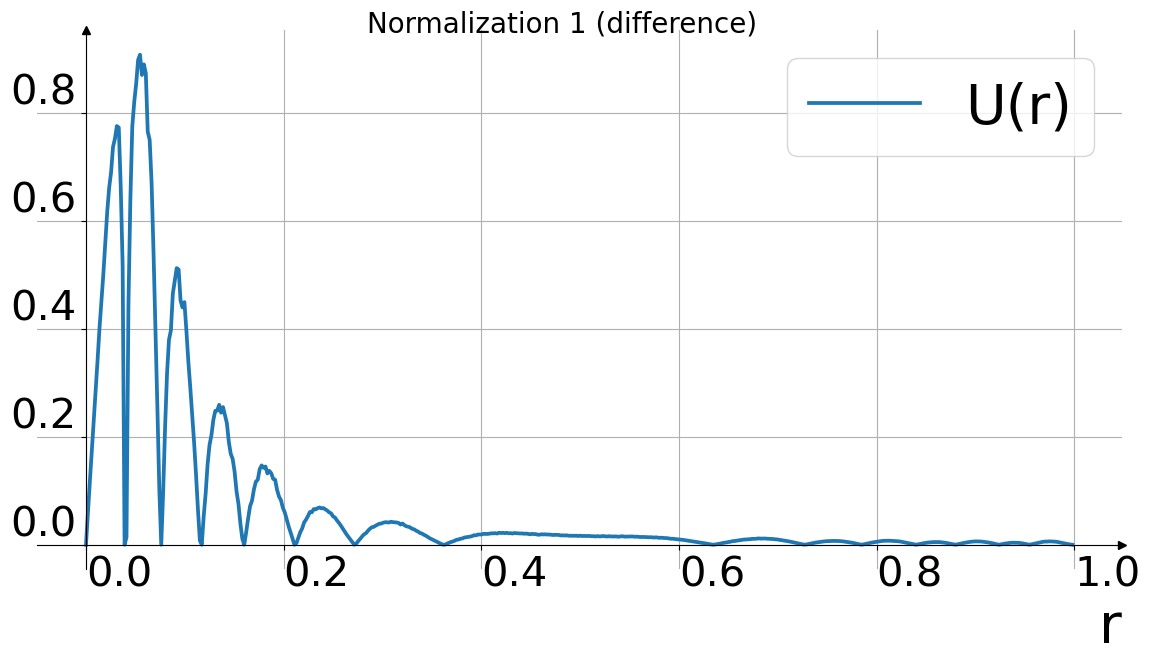

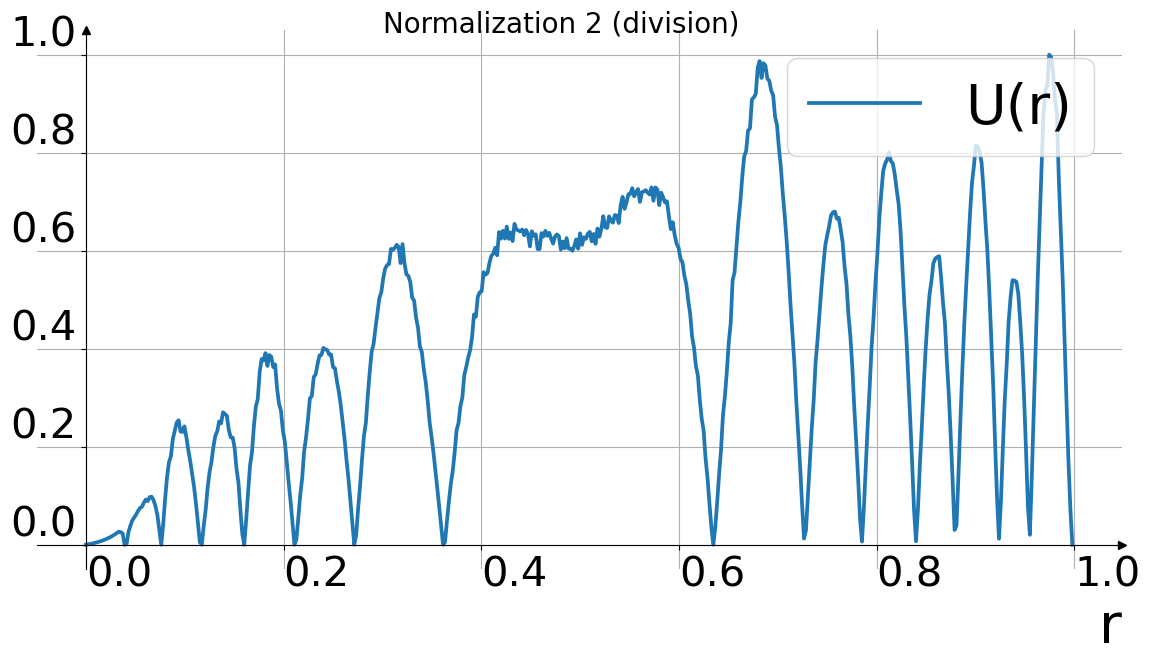

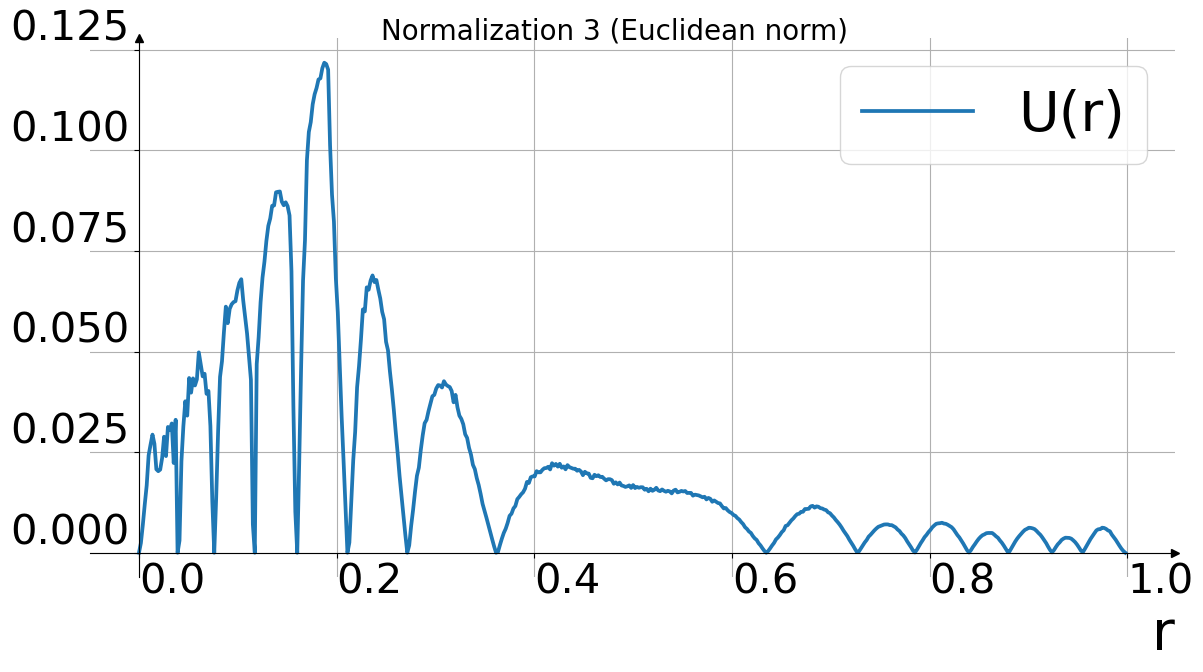

In [10]:
norm2 = average_angled_spectrum / (envelope + 1e-10) - 1
norm2 = norm2 / np.max(norm2)
average_angled_spectrum_norm = OTF_Restoration.normalize_by_envelope(average_angled_spectrum, envelope)

Plotting.plot_functions([Plotting.FuncDesc(x, average_angled_spectrum - envelope, 'U(r)')], title='Normalization 1 (difference)', x_axis_name='r')
Plotting.plot_functions([Plotting.FuncDesc(x, norm2, 'U(r)')], title='Normalization 2 (division)', x_axis_name='r')
Plotting.plot_functions([Plotting.FuncDesc(x, average_angled_spectrum_norm, 'U(r)')], title='Normalization 3 (Euclidean norm)', x_axis_name='r')